In [12]:
!pip install pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


In [13]:
import pandas as pd
import os
import re

In [14]:
def parse_usages(usage_string):
    usages = []
    usage_string = usage_string.replace("),C",")\tC")
    usage_string = usage_string.split("\t")
    usages_pattern = r"[A-Za-z]PU: \([^)]*\)"
    cpu_usage_pattern = r"maxrss: (\d+MiB)"
    gpu_usage_pattern = r"U: (\d+MiB)"
    mapper = {
        0: "before (MiB)",
        1: "after (MiB)"
    }
    for i, moments in enumerate(usage_string):
            matches = re.findall(usages_pattern, moments)
            for match in matches:
                match = match.replace(",","")
                cpu = re.findall(cpu_usage_pattern, match)
                gpu = re.findall(gpu_usage_pattern, match)
                if match[:3] == "CPU":
                    usages.append({f"{match[:3]}-{mapper[i]}":int(cpu[0].replace("MiB",""))})
                elif match[:3] == "GPU":
                    usages.append({f"{match[:3]}-{mapper[i]}":int(gpu[0].replace("MiB",""))})                    
    return usages
            
        

In [15]:
def parse_file(file):
    lazy_load = True if "--lazy-load" in file else False
    vllm_tensorized = True if "--plaid-mode"in file else False
    df = pd.read_csv(file)
    rows = []
    for i in range(len(df)):
        row = df.iloc[i]
        load_format = row.name[0]
        model = row.name[1]
        duration = row[-2]
        cache = row[-1]
        to_concat = row.name[2:]
        mem_before_after = ",".join(to_concat)
        vals = {}
        vals.update({"load_format":load_format})
        vals.update({"model":model})
        for dic in parse_usages(mem_before_after):
            vals.update(dic)
        vals.update({"duration(s)":duration})
        vals.update({"cache_hit":cache})
        vals.update({"lazy_load":lazy_load})
        vals.update({"vllm_tensorized":vllm_tensorized})
        cpu_diff = vals["CPU-after (MiB)"] - vals["CPU-before (MiB)"]
        gpu_diff = vals["GPU-after (MiB)"] - vals["GPU-before (MiB)"]
        vals.update({"CPU-diff-MiB": cpu_diff})
        vals.update({"GPU-diff-MiB": gpu_diff})
        rows.append(vals)
    return pd.DataFrame(rows)


In [16]:
files = [file for file in os.listdir() if file.isnumeric()]
dfs = []
for file in files:
    load_type = os.listdir(file)[0]
    model_ref_1 = os.listdir(f"{file}/{load_type}")[0]
    model_ref_2 = os.listdir(f"{file}/{load_type}/{model_ref_1}")[0]
    localities = os.listdir(f"{file}/{load_type}/{model_ref_1}/{model_ref_2}")
    for locality in localities:
        subpath = f"{file}/{load_type}/{model_ref_1}/{model_ref_2}/{locality}"
        benchmark_files = os.listdir(subpath)
        for benchmark in benchmark_files:
            created_df = parse_file(f"{subpath}/{benchmark}")
            created_df["local_or_not_local"] = locality
            dfs.append(created_df)
df = pd.concat(dfs)
        

/tmp/ipykernel_808387/3683185005.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  duration = row[-2]
/tmp/ipykernel_808387/3683185005.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cache = row[-1]
/tmp/ipykernel_808387/3683185005.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  duration = row[-2]
/tmp/ipykernel_808387/3683185005.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

In [17]:
df['vllm_tensorized'] = ['plaid_mode' if x == True else '' for x in df['vllm_tensorized']]

In [18]:
df['lazy_load'] = ['lazy_load' if x == True else '' for x in df['lazy_load']]

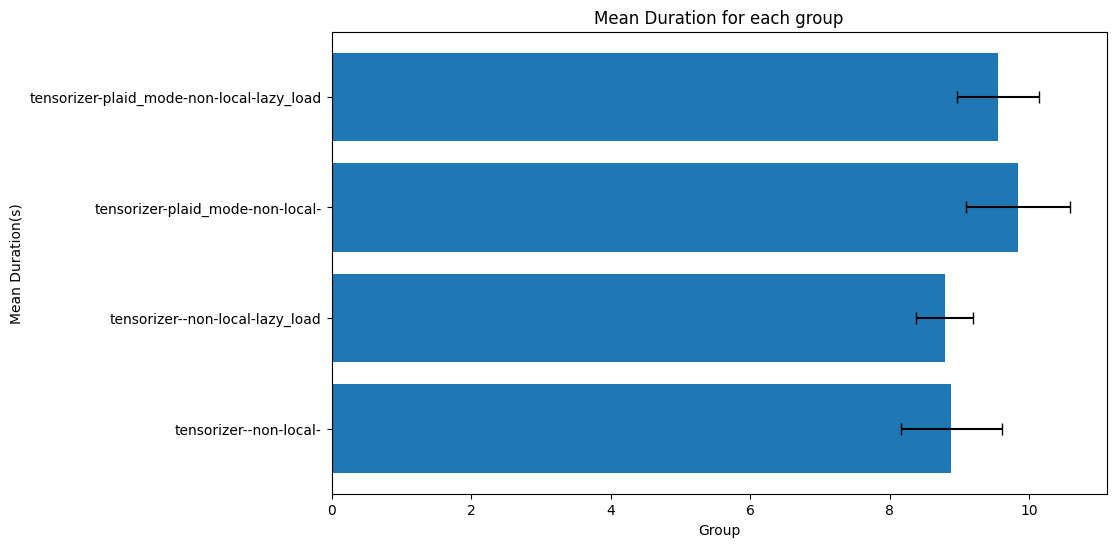

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column that represents each unique combination of the three variables
df['group'] = "tensorizer"+"-"+df['vllm_tensorized'].astype(str) + "-" + df['local_or_not_local'].astype(str) + "-" + df['lazy_load'].astype(str)

# Calculate mean and standard deviation
grouped = df.groupby('group')['duration(s)']
mean = grouped.mean()
std = grouped.std()

# Create bar plot with error bars
plt.figure(figsize=(10, 6))
plt.barh(mean.index, mean, xerr=std, capsize=4, align='center')

plt.ylabel('Mean Duration(s)')
plt.xlabel('Group')
plt.title('Mean Duration for each group')
plt.show()

In [11]:
set(df['model'])

{'meta-llama/Llama-2-13b-hf'}